### Analysis of Planck's Law with Data Fitting
-By Siva Sundar (EE23B151)

In this notebook, we will:
1. Extract XY data points from multiple files.
2. Plot the data points.
3. Fit a model to the data.
4. Fit Planck's Law to the data and estimate parameters.

We will use the following libraries:
- `matplotlib.pyplot` for plotting.
- `numpy` for numerical operations.
- `scipy.optimize` for curve fitting.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

The following function reads data from a file and returns X and Y coordinates.


In [2]:
def XY_extract(filename):
    # Read the data from the file
    with open(filename, "r") as file:
        lines = file.readlines()

    # Taking X and Y coords from the file
    X = []
    Y = []

    # Process each line and split into x and y values
    for line in lines:
        x, y = line.strip().split(',')
        X.append(float(x))  # Convert x to float
        Y.append(float(y))  # Convert y to float

    return X, Y

We will now extract data from the specified files and store the X and Y values in separate lists.


In [3]:
filenames = ["d1.txt", "d2.txt", "d3.txt", "d4.txt"]
X = []; Y = []              # Contains all the X and Y values of the files

for filename in filenames:
    X_val, Y_val = XY_extract(filename)
    X.append(X_val); Y.append(Y_val)

This section creates subplots to visualize the data points from each file.

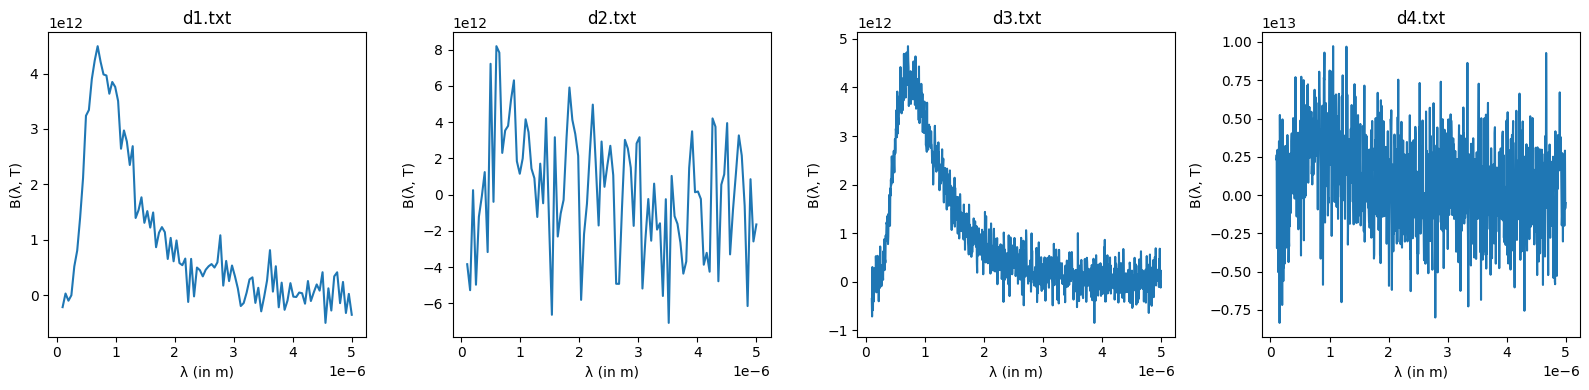

In [12]:
# Create subplots with 1 row and 4 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))  # Adjust figsize for better visualization

# Plotting the files
count = 0
for ax in axes:
    ax.plot(X[count], Y[count])
    ax.set_title(f"d{count+1}.txt")
    ax.set_xlabel("λ (in m)")
    ax.set_ylabel("B(λ, T)")
    count += 1

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

Key-points to note from the above graphs:

- The amplitude and amount of noise in `d1.txt` is the **least**.

- The amplitude of noise is **highest** in `d2.txt` and `d4.txt`.

- The amount of noise is **highest** in `d3.txt` and `d4.txt`.

#### **Model for Planck's Law with Condensed Constants**

To simplify Planck's Law, we define two condensed constants, `a` and `b`:

1. **Constant `a`**:
   - Defined as: $a = 2hc^2$
   - For the given values of Planck's constant $ h $, the speed of light $ c $, the value of $ a $ is approximately:
     $$
     a = 1.194 \times 10^{-16} \, \text{W} \cdot \text{m}^2
     $$

2. **Constant `b`**:
   - Defined as: $b = \frac{hc}{k_B \cdot T}$
   - For a temperature of 4000 K, the value of $b$ is: $b = 3.6 \times 10^{-6} \, \text{m}$

Using these constants, Planck's Law can be simplified to:
$$
B(\lambda) = \frac{a}{\lambda^5} \cdot \frac{1}{e^{\left(\frac{b}{\lambda}\right)} - 1}
$$
where $ \lambda $ is the wavelength (in metres), and $ a $ and $b$ are the condensed constants.

This simplified model helps in fitting and analyzing spectral data more conveniently.


In [5]:
def model(L, a, b):     # Temp being a constant
    return a*(1/L**5)*(1/(np.expm1(b/(L*1e5))))

We will fit the model to each dataset and plot the estimated values alongside the original data.


File 'd1.txt' => Estimated 'a': 1.159e-16, 'b': 3.560e-06
File 'd2.txt' => Estimated 'a': 7.704e-17, 'b': 3.338e-06
File 'd3.txt' => Estimated 'a': 1.130e-16, 'b': 3.559e-06
File 'd4.txt' => Estimated 'a': 1.127e-16, 'b': 3.644e-06


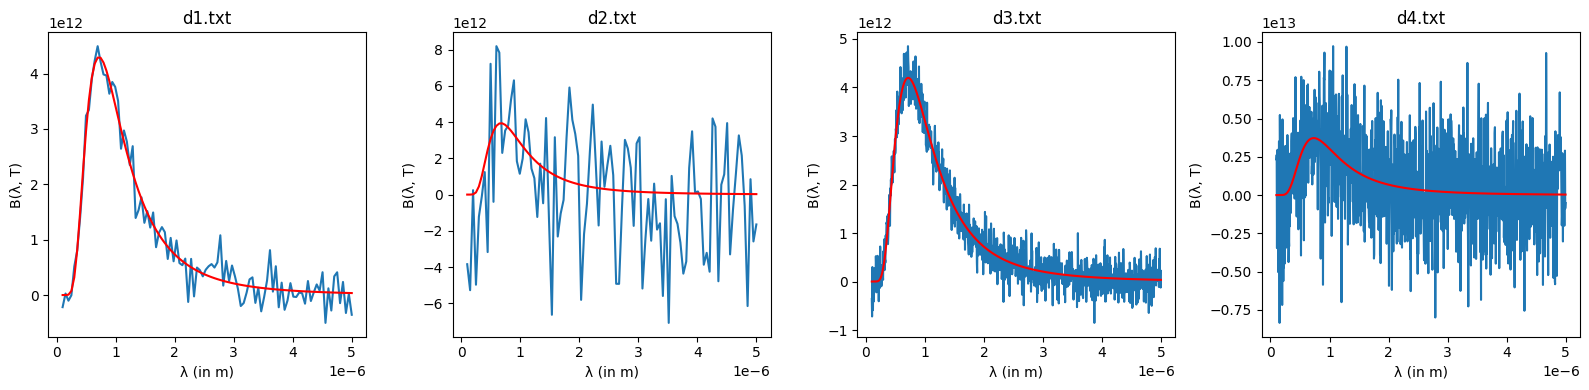

In [11]:
Y_est = []          # Stores the estimated Y values using model fitted with the dataset
file_no = 0
for (x,y) in (zip(X,Y)):
    file_no += 1
    (a, b), _ = curve_fit(model, x, y)
    
    y_est = []
    for x in X[file_no-1]:
        y_est.append(model(x, a, b))
    Y_est.append(y_est)
    print(f"File 'd{file_no}.txt' => Estimated 'a': {a:.3e}, 'b': {b/1e5:.3e}")

# Create subplots with 1 row and 4 columns
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))  # Adjust figsize for better visualization

# Plotting the files
count = 0
for ax in axes:
    ax.plot(X[count], Y[count])
    ax.plot(X[count], Y_est[count], color = "red")
    ax.set_title(f"d{count+1}.txt")
    ax.set_xlabel("λ (in m)")
    ax.set_ylabel("B(λ, T)")
    count += 1

# Adjust spacing between plots
plt.tight_layout()

# Show the plot
plt.show()

Even with high noise, d4.txt gave a better 'a' and 'b' value than d2.txt

This section fits the **actual** Planck's Law to the data with different parameter combinations and prints the results in a formatted table.

In [7]:
def planck_law(lambda_, h, c, k_B, T):
    # Clip the result to avoid extreme values
    exp_term_clipped = np.exp(np.clip(h*c / (lambda_ * k_B * T), None, 1000))
    return (2*h*c**2) / (lambda_**5 * (exp_term_clipped - 1))

The following function fits Planck's Law to the data $X$ and $Y$, using a set of known parameters $(h, c, k_B, T)$. It performs the following:

1. **Fitting with 3 Known Constants**:
   Estimates the fourth constant by fitting the model with three known values.

2. **Fitting with 2 Known Constants**:
   Estimates the remaining two constants by fitting the model with two known values.

Each fitting scenario is reported with the estimated values of the unknown constants.


In [8]:
def curve_fitter(X, Y, correct):
    # Perform curve fitting and print results
    results = []

    # Perform curve fitting to find T value assuming correct values of h, c and k_b are known
    (T_fit,), _ = curve_fit(lambda X, T: planck_law(X, correct[0], correct[1], correct[2], T), X, Y, p0=correct[3])
    results.append(f"{T_fit:.2f}")

    # Perform curve fitting to find h value assuming correct values of c, k_b and T are known
    (h_fit,), _ = curve_fit(lambda X, h: planck_law(X, h, correct[1], correct[2], correct[3]), X, Y, p0=correct[0])
    results.append(f"{h_fit:.3e}")

    # Perform curve fitting to find c value assuming correct values of h, k_b and T are known
    (c_fit,), _ = curve_fit(lambda X, c: planck_law(X, correct[0], c, correct[2], correct[3]), X, Y, p0=correct[1])
    results.append(f"{c_fit:.3e}")

    # Perform curve fitting to find k_b value assuming correct values of h, c and T are known
    (k_fit,), _ = curve_fit(lambda X, k: planck_law(X, correct[0], correct[1], k, correct[3]), X, Y, p0=correct[2])
    results.append(f"{k_fit:.3e}")

    # Perform curve fitting to find h and T given c and k_b are known
    (h_fit, T_fit), _ = curve_fit(lambda X, h, T: planck_law(X, h, correct[1], correct[2], T), X, Y, p0=[correct[0], correct[3]])
    results.append(f"h = {h_fit:.3e}, T = {T_fit:.2f}")

    # Perform curve fitting to find h and k_b given c and T are known
    (h_fit, k_fit), _ = curve_fit(lambda X, h, k: planck_law(X, h, correct[1], k, correct[3]), X, Y, p0=[correct[0], correct[2]])
    results.append(f"h = {h_fit:.3e}, k_b = {k_fit:.3e}")

    # Perform curve fitting to find c and k_b given h and T are known
    (c_fit, k_fit), _ = curve_fit(lambda X, c, k: planck_law(X, correct[0], c, k, correct[3]), X, Y, p0=[correct[1], correct[2]])
    results.append(f"c = {c_fit:.3e}, k_b = {k_fit:.3e}")

    # Perform curve fitting to find c and T given h and k_b are known
    (c_fit, T_fit), _ = curve_fit(lambda X, c, T: planck_law(X, correct[0], c, correct[2], T), X, Y, p0=[correct[1], correct[3]])
    results.append(f"c = {c_fit:.3e}, T = {T_fit:.2f}")

    # Print the results in a table-like format
    print(f"{'Condition':<30}{'Output Values':<20}")
    print('-' * 55)
    print(f"Given h, c, k_b \tT = {results[0]:<20}")
    print(f"Given c, k_b, T \th = {results[1]:<20}")
    print(f"Given h, k_b, T \tc = {results[2]:<20}")
    print(f"Given h, c, T \t\tk_b = {results[3]:<20}")
    print(f"Given c, k_b \t\t{results[4]:<20}")
    print(f"Given c, k_b \t\t{results[5]:<20}")
    print(f"Given c, k_b \t\t{results[6]:<20}")
    print(f"Given c, k_b \t\t{results[7]:<20}")

Using the `curve_fitter` function to each dataset and prints the results.


In [9]:
# Correct parameter values
correct = [6.626e-34, 3e8, 1.381e-23, 4000]  # h, c, k_B, and T (temperature)

file_no = 0
for (x, y) in zip(X, Y):
    file_no += 1
    print(f"\nFor file 'd{file_no}.txt':")
    curve_fitter(x, y, correct)


For file 'd1.txt':
Condition                     Output Values       
-------------------------------------------------------
Given h, c, k_b 	T = 4020.40             
Given c, k_b, T 	h = 6.583e-34           
Given h, k_b, T 	c = 2.974e+08           
Given h, c, T 		k_b = 1.388e-23           
Given c, k_b 		h = 6.440e-34, T = 3929.80
Given c, k_b 		h = 6.440e-34, k_b = 1.357e-23
Given c, k_b 		c = 2.957e+08, k_b = 1.376e-23
Given c, k_b 		c = 2.957e+08, T = 3986.29

For file 'd2.txt':
Condition                     Output Values       
-------------------------------------------------------
Given h, c, k_b 	T = 3957.28             
Given c, k_b, T 	h = 6.687e-34           
Given h, k_b, T 	c = 3.009e+08           
Given h, c, T 		k_b = 1.366e-23           
Given c, k_b 		h = 4.279e-34, T = 2785.03
Given c, k_b 		h = 4.279e-34, k_b = 9.615e-24
Given c, k_b 		c = 2.412e+08, k_b = 1.197e-23
Given c, k_b 		c = 2.412e+08, T = 3465.99

For file 'd3.txt':
Condition                     Output